## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
#import modules
import os
import numpy as np
import math
from numba import jit, njit, vectorize, cuda, vectorize, int64, float32, float64
import matplotlib.pyplot as plt

In [2]:
A = np.array([2, 5, 10, 3, 8],dtype="float32")

@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_log(x):
    return np.log(x)

@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_exp(x):
    return np.exp(x)

print("Log:", vec_log(A))
print("Exp:", vec_exp(A))

Log: [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Exp: [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

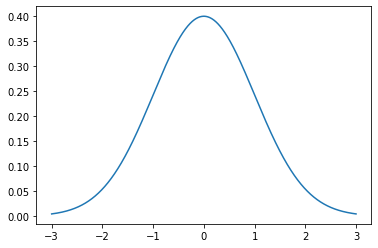

In [3]:
@vectorize([float64(float32)], target='parallel', fastmath=True) 
def vectorized_gaussian(x):
    return 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)

x =  np.linspace(-3, 3, num = 100000, dtype = np.float32)
plt.plot(x,vectorized_gaussian(x))
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

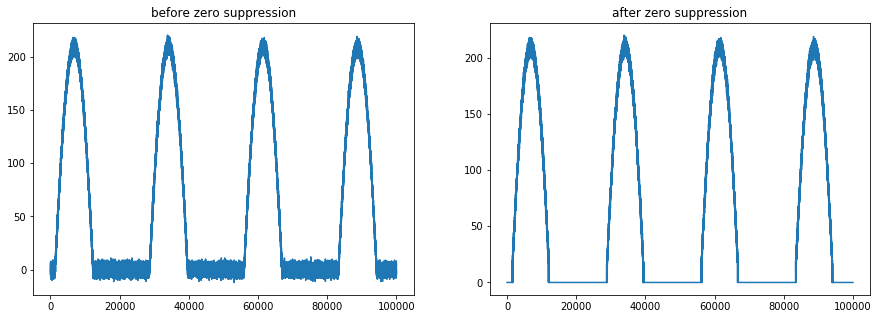

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

@vectorize([float32(float32, float32)], target = 'parallel', fastmath = True)
def zero_suppress(x,treshold):
    return x * (x>treshold)

treshold = 15
fig,ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].plot(data)
ax[0].set_title("before zero suppression")
ax[1].plot(zero_suppress(data,treshold))
ax[1].set_title("after zero suppression")
plt.show()
    

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@jit(nopython=True)
def sigmoid_kernel(x, y, alpha, c):
    return np.tanh(alpha*np.dot(x.T,y) + c)

print("Sigmoid kernel =", '\n', sigmoid_kernel(X,Y,1,0))

Sigmoid kernel = 
 [[0.59184318 0.30902865 0.50931839]
 [0.78056344 0.40570498 0.68433524]
 [0.62627646 0.25256505 0.54205478]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
@cuda.jit
def kernel(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x,y,z] = math.cos(io_array[x,y,z])

# Host code   
data = np.random.random((256,256,256))

# Configure the blocks
threadsperblock = (8,4,4)
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

kernel[blockspergrid, threadsperblock](data)

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [7]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(1,10,(24,12))
B = np.random.randint(1,10,(12,22))
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (4,2)
blockspergrid_x = int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)
